In [1]:
import ee

# Trigger the authentication flow.
ee.Authenticate()


In [2]:
# Initialize the library.
ee.Initialize(project="pyregence-ee", opt_url="https://earthengine-highvolume.googleapis.com")

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
import json
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
state = "CA"
full_state_name = "California"

# also k parameter in the Poisson generation function:
# The number of attempts to find a valid point around the reference point.
iter_attempt = 500

# Also r in the poisson generation function (in km)
# The minimum distance between points in the sample.
poisson_point_distance = 5

start_year = 1990
end_year = 2023

gdrive_base_path = "/content/drive/MyDrive/Colab_Notebooks/NASA_Fire_Probabilities/data"
poisson_data_outpath_base = f"{gdrive_base_path}/poisson-data"
poisson_outpath = f"{poisson_data_outpath_base}/{state}-poisson-data/{state}_1km_k{iter_attempt}_r{poisson_point_distance}"


In [6]:
wrf_variable_name = 'relative-humidity' # 'relative-humidity', 'soil-moisture', 'wrf-data-etrans-sfc', 'surface-sensible-heat
# gcs_variable_name = 'soil_m' # 'etrans_sfc', 'sh_sfc, 'soil_m
soil_level_name = 'soil_m_level'

In [7]:
terra_climate = ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE")
wrf_variable = ee.ImageCollection(f"projects/pyregence-ee/assets/wrf-data/{wrf_variable_name}").filterDate(f"{start_year}-01-01", f"{end_year}-12-31")


In [9]:
ee.List.sequence(start_year, end_year).getInfo()

[1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022,
 2023]

In [53]:
aet = terra_climate.filterDate(f"{start_year}-01-01", f"{end_year}-12-31").select("aet")
aet = ee.ImageCollection(ee.List.sequence(start_year, end_year).map(
    lambda year: aet.filterDate(
        ee.Date.fromYMD(year, 1, 1),
        ee.Date.fromYMD(ee.Number(year).add(1), 1, 1)
    ).mean().set("system:time_start", ee.Date.fromYMD(year, 1, 1).millis())
))


In [54]:
pet = terra_climate.filterDate(f"{start_year}-01-01", f"{end_year}-12-31").select("pet")
pet = ee.ImageCollection(ee.List.sequence(start_year, end_year).map(
    lambda year: pet.filterDate(
        ee.Date.fromYMD(year, 1, 1),
        ee.Date.fromYMD(ee.Number(year).add(1), 1, 1)
    ).mean().set("system:time_start", ee.Date.fromYMD(year, 1, 1).millis())
))


In [55]:
wrf_variable.size().getInfo(), aet.size().getInfo(), pet.size().getInfo()

(34, 34, 34)

In [56]:
in_gdf = gpd.read_file(f"{poisson_outpath}.shp")
out_gdf = in_gdf.to_crs(epsg="4326")
poisson_point_geo_json = json.loads(out_gdf.to_json())
poisson_point_ee = ee.FeatureCollection(poisson_point_geo_json)

In [57]:
start_year, end_year

(1990, 2023)

## Correlation Matrix

dict_keys(['sample_cwd_norm', 'sample_aet_dev', 'sample_cwd_dev', 'sample_aet_original', 'sample_pet_original', 'sample_soil_m'])
11309 11309 11309 11309 11309 11309


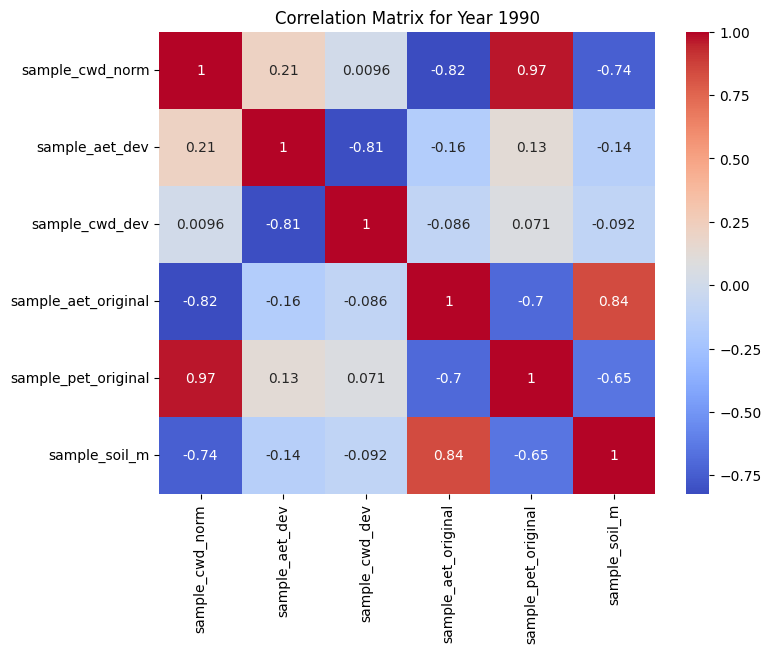

In [ ]:
data = {}
for year in range(start_year, end_year+1):
    terra_climate_aet_norm = terra_climate.filterDate("1970-01-01", f"{end_year}-12-31").select("aet").mean().unmask(0).rename("aet_norm").float()
    terra_climate_pet_norm = terra_climate.filterDate("1970-01-01", f"{end_year}-12-31").select("pet").mean().unmask(0).rename("pet_norm").float()

    terra_climate_cwd_norm = terra_climate_pet_norm.subtract(terra_climate_aet_norm).rename("cwd_norm").float()

    # filter annual terra_climate aet & pet, calculate cwd
    terra_climate_aet = terra_climate.filterDate(f"{year-3}-01-01", f"{year-1}-12-31").select("aet").mean().unmask(0).rename("aet")
    terra_climate_pet = terra_climate.filterDate(f"{year-3}-01-01", f"{year-1}-12-31").select("pet").mean().unmask(0).rename("pet")
    terra_climate_cwd = terra_climate_pet.subtract(terra_climate_aet).rename("cwd")

    # calculate devs from climate norms
    terra_climate_aet_dev = terra_climate_aet.subtract(terra_climate_aet_norm).rename("aet_dev").float()
    terra_climate_cwd_dev = terra_climate_cwd.subtract(terra_climate_cwd_norm).rename("cwd_dev").float()

    terra_climate_aet_original = terra_climate.filterDate(f"{year}-01-01", f"{year+1}-01-01").select("aet").mean().unmask(0).rename("aet")
    terra_climate_pet_original = terra_climate.filterDate(f"{year}-01-01", f"{year+1}-01-01").select("pet").mean().unmask(0).rename("pet")

    wrf_variable_year = wrf_variable.filterDate(f"{year}-01-01", f"{year+1}-01-01").mean().unmask(0).rename(gcs_variable_name)


    poisson_point_ee = poisson_point_ee.map(lambda f: f.set("year", year))

    sample_cwd_norm = terra_climate_cwd_norm.sampleRegions(poisson_point_ee, geometries=False).aggregate_array("cwd_norm").getInfo()
    sample_aet_dev = terra_climate_aet_dev.sampleRegions(poisson_point_ee, geometries=False).aggregate_array("aet_dev").getInfo()
    sample_cwd_dev = terra_climate_cwd_dev.sampleRegions(poisson_point_ee, geometries=False).aggregate_array("cwd_dev").getInfo()

    sample_aet_original = terra_climate_aet_original.sampleRegions(poisson_point_ee, geometries=False).aggregate_array("aet").getInfo()
    sample_pet_original = terra_climate_pet_original.sampleRegions(poisson_point_ee, geometries=False).aggregate_array("pet").getInfo()

    # sample_wrf_variable = wrf_variable_year.sampleRegions(poisson_point_ee, geometries=False).aggregate_array("etrans_sfc").getInfo()
    sample_wrf_variable = wrf_variable_year.sampleRegions(poisson_point_ee, geometries=False).aggregate_array(gcs_variable_name).getInfo()

    sample_data = {
        "sample_cwd_norm": sample_cwd_norm,
        "sample_aet_dev": sample_aet_dev,
        "sample_cwd_dev": sample_cwd_dev,
        "sample_aet_original": sample_aet_original,
        "sample_pet_original": sample_pet_original,
        f"sample_{gcs_variable_name}": sample_wrf_variable,
    }

    print(sample_data.keys())
    print(len(sample_cwd_norm), len(sample_aet_dev), len(sample_cwd_dev),
          len(sample_aet_original), len(sample_pet_original), len(sample_wrf_variable)
        )

    data[year] = sample_data

    df = pd.DataFrame(sample_data)

    correlation_matrix = df.corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title(f'Correlation Matrix for Year {year}')
    plt.show()
    break


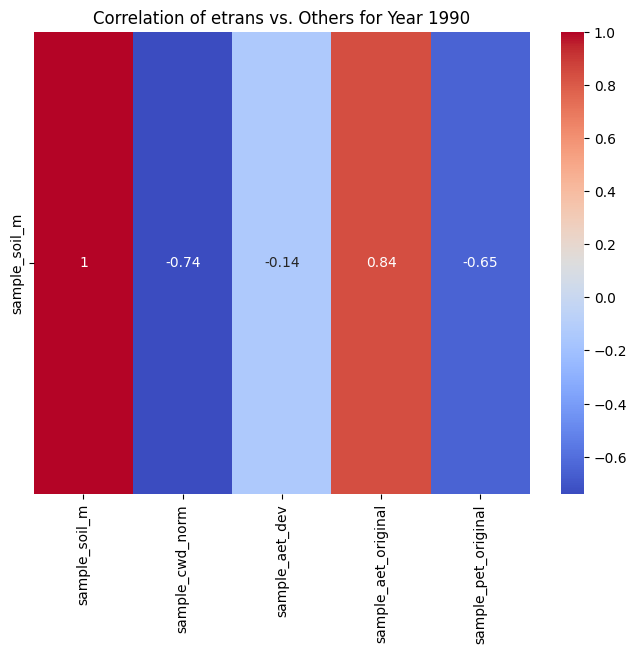

In [ ]:
data = {}
for year in range(start_year, end_year+1):
    terra_climate_aet_norm = terra_climate.filterDate("1970-01-01", f"{end_year}-12-31").select("aet").mean().unmask(0).rename("aet_norm").float()
    terra_climate_pet_norm = terra_climate.filterDate("1970-01-01", f"{end_year}-12-31").select("pet").mean().unmask(0).rename("pet_norm").float()

    terra_climate_cwd_norm = terra_climate_pet_norm.subtract(terra_climate_aet_norm).rename("cwd_norm").float()

    # filter annual terra_climate aet & pet, calculate cwd
    terra_climate_aet = terra_climate.filterDate(f"{year-3}-01-01", f"{year-1}-12-31").select("aet").mean().unmask(0).rename("aet")
    terra_climate_pet = terra_climate.filterDate(f"{year-3}-01-01", f"{year-1}-12-31").select("pet").mean().unmask(0).rename("pet")
    terra_climate_cwd = terra_climate_pet.subtract(terra_climate_aet).rename("cwd")

    # calculate devs from climate norms
    terra_climate_aet_dev = terra_climate_aet.subtract(terra_climate_aet_norm).rename("aet_dev").float()
    terra_climate_cwd_dev = terra_climate_cwd.subtract(terra_climate_cwd_norm).rename("cwd_dev").float()

    terra_climate_aet_original = terra_climate.filterDate(f"{year}-01-01", f"{year+1}-01-01").select("aet").mean().unmask(0).rename("aet")
    terra_climate_pet_original = terra_climate.filterDate(f"{year}-01-01", f"{year+1}-01-01").select("pet").mean().unmask(0).rename("pet")

    wrf_variable_year = wrf_variable.filterDate(f"{year}-01-01", f"{year+1}-01-01").mean().unmask(0).rename(gcs_variable_name)


    poisson_point_ee = poisson_point_ee.map(lambda f: f.set("year", year))

    sample_cwd_norm = terra_climate_cwd_norm.sampleRegions(poisson_point_ee, geometries=False).aggregate_array("cwd_norm").getInfo()
    sample_aet_dev = terra_climate_aet_dev.sampleRegions(poisson_point_ee, geometries=False).aggregate_array("aet_dev").getInfo()
    sample_cwd_dev = terra_climate_cwd_dev.sampleRegions(poisson_point_ee, geometries=False).aggregate_array("cwd_dev").getInfo()

    sample_aet_original = terra_climate_aet_original.sampleRegions(poisson_point_ee, geometries=False).aggregate_array("aet").getInfo()
    sample_pet_original = terra_climate_pet_original.sampleRegions(poisson_point_ee, geometries=False).aggregate_array("pet").getInfo()

    sample_wrf_etrans = wrf_variable_year.sampleRegions(poisson_point_ee, geometries=False).aggregate_array(gcs_variable_name).getInfo()

    sample_data = {
        "sample_cwd_norm": sample_cwd_norm,
        "sample_aet_dev": sample_aet_dev,
        "sample_cwd_dev": sample_cwd_dev,
        "sample_aet_original": sample_aet_original,
        "sample_pet_original": sample_pet_original,
        f"sample_{gcs_variable_name}": sample_wrf_variable,
    }

    data[year] = sample_data

    df = pd.DataFrame(sample_data)

    wrf_etrans_corr = df[[f"sample_{gcs_variable_name}", "sample_cwd_norm", "sample_aet_dev", "sample_aet_original", "sample_pet_original"]].corr()

    # Extract correlations between etrans and other variables
    etrans_vs_others = wrf_etrans_corr.loc[f"sample_{gcs_variable_name}"]

    plt.figure(figsize=(8, 6))
    sns.heatmap(etrans_vs_others.to_frame().transpose(), annot=True, cmap='coolwarm')
    plt.title(f'Correlation of etrans vs. Others for Year {year}')
    plt.show()
    break


## Long-term Avg Correlation Maps

#### x-array

In [17]:
!pip install --upgrade xee rioxarray cartopy

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.6/242.6 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.2 MB/s eta 0:00:00


In [18]:
import xarray
import rioxarray  # For CRS handling
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

In [41]:
wrf_variable_name, soil_level_name

('relative-humidity', 'soil_m_level')

In [58]:
if wrf_variable_name == 'soil-moisture':
    soil_level = 1
    wrf_variable_l = wrf_variable.filter(ee.Filter.eq(name=soil_level_name, value=soil_level))
else:
    wrf_variable_l = wrf_variable

In [59]:
wrf_variable_l.size().getInfo()

34

In [60]:
type(wrf_variable_l), type(wrf_variable)

(ee.imagecollection.ImageCollection, ee.imagecollection.ImageCollection)

In [61]:
# Open as an Xarray Dataset using Xee
ds_wrf = xarray.open_dataset(wrf_variable_l, crs='EPSG:4326', engine='ee', scale=0.2, geometry=wrf_variable.first().geometry())

In [62]:
ds_wrf

<xarray.Dataset> Size: 5MB
Dimensions:  (time: 34, lon: 218, lat: 177)
Coordinates:
  * time     (time) datetime64[ns] 272B 1990-01-01 1991-01-01 ... 2023-01-01
  * lon      (lon) float64 2kB -138.4 -138.2 -138.0 ... -95.38 -95.18 -94.98
  * lat      (lat) float64 1kB 22.29 22.49 22.69 22.89 ... 57.09 57.29 57.49
Data variables:
    B0       (time, lon, lat) float32 5MB ...
Attributes:
    crs:      EPSG:4326

In [63]:
ds_wrf_time_series = ds_wrf['B0']

In [64]:
wrf_time_series = ds_wrf_time_series.compute()
wrf_time_series = wrf_time_series.squeeze()
wrf_time_series.shape

(34, 218, 177)

In [65]:
# # Select a specific lat/lon point for plotting the time series
# lat_point = ds_wrf.lat[0] #22.688243
# lon_point = ds_wrf.lon[0] # -137.977174

# # Select the time series for the specific lat/lon point
# wrf_time_series_point = wrf_time_series.sel(lat=lat_point, lon=lon_point, method='nearest')

# # Now plot the time series for that point
# fig, ax = plt.subplots(1, 1)
# fig.set_size_inches(10, 5)
# wrf_time_series_point.plot.line(
#     ax=ax, x='time',
#     marker='o', color='#66c2a4', linestyle='--', linewidth=1, markersize=4
# )
# plt.show()


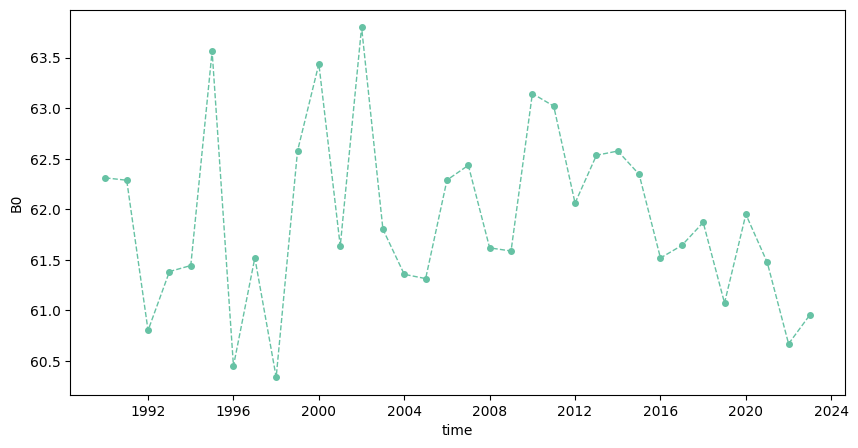

In [66]:
# Average over lat and lon dimensions to get a 1D time series
wrf_time_series_avg = wrf_time_series.mean(dim=['lat', 'lon'])

# Now plot the averaged time series
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 5)
wrf_time_series_avg.plot.line(
    ax=ax, x='time',
    marker='o', color='#66c2a4', linestyle='--', linewidth=1, markersize=4
)
plt.show()


In [67]:
# Open as an Xarray Dataset using Xee
ds_aet = xarray.open_dataset(aet, crs='EPSG:4326', engine='ee', scale=0.2, geometry=wrf_variable.first().geometry())
ds_pet = xarray.open_dataset(pet, crs='EPSG:4326', engine='ee', scale=0.2, geometry=wrf_variable.first().geometry())


In [68]:
ds_aet

<xarray.Dataset> Size: 5MB
Dimensions:  (time: 34, lon: 218, lat: 177)
Coordinates:
  * time     (time) datetime64[ns] 272B 1990-01-01 1991-01-01 ... 2023-01-01
  * lon      (lon) float64 2kB -138.4 -138.2 -138.0 ... -95.38 -95.18 -94.98
  * lat      (lat) float64 1kB 22.29 22.49 22.69 22.89 ... 57.09 57.29 57.49
Data variables:
    aet      (time, lon, lat) float32 5MB ...
Attributes:
    crs:      EPSG:4326

In [69]:
ds_pet

<xarray.Dataset> Size: 5MB
Dimensions:  (time: 34, lon: 218, lat: 177)
Coordinates:
  * time     (time) datetime64[ns] 272B 1990-01-01 1991-01-01 ... 2023-01-01
  * lon      (lon) float64 2kB -138.4 -138.2 -138.0 ... -95.38 -95.18 -94.98
  * lat      (lat) float64 1kB 22.29 22.49 22.69 22.89 ... 57.09 57.29 57.49
Data variables:
    pet      (time, lon, lat) float32 5MB ...
Attributes:
    crs:      EPSG:4326

In [70]:
aet_time_series = ds_aet.aet
pet_time_series = ds_pet.pet


In [71]:
wrf_time_series = wrf_time_series.rio.write_crs("EPSG:4326")
aet_time_series = aet_time_series.rio.write_crs("EPSG:4326")
pet_time_series = pet_time_series.rio.write_crs("EPSG:4326")

In [72]:
# Compute the correlation between wrf_time_series and aet_time_series across the 'time' dimension
corr_wrf_aet = xarray.corr(wrf_time_series, aet_time_series, dim='time')

# Compute the correlation between wrf_time_series and pet_time_series across the 'time' dimension
corr_wrf_pet = xarray.corr(wrf_time_series, pet_time_series, dim='time')


In [73]:
corr_wrf_aet = corr_wrf_aet.rio.write_crs("EPSG:4326")
corr_wrf_pet = corr_wrf_pet.rio.write_crs("EPSG:4326")

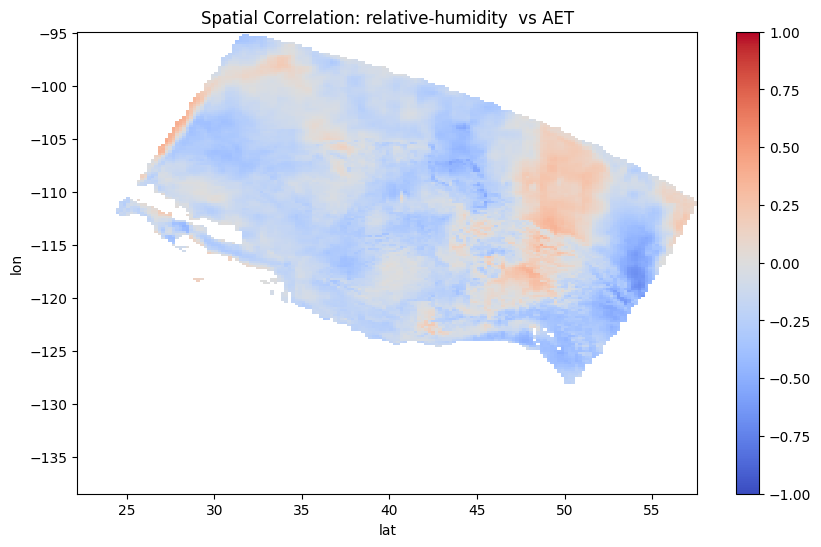

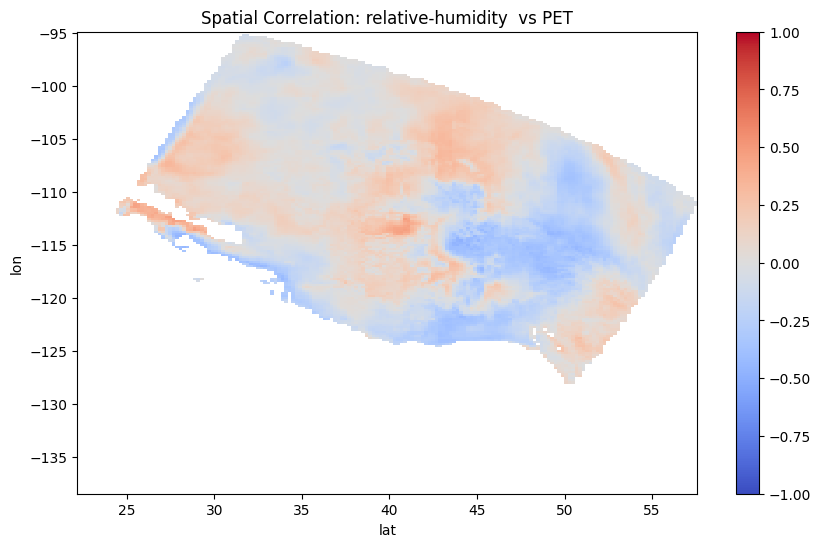

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
corr_wrf_aet.plot(ax=ax, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_title(f"Spatial Correlation: {wrf_variable_name} {'Level: '+ str(soil_level) if wrf_variable_name == 'soil-moisture' else ''} vs AET")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
corr_wrf_pet.plot(ax=ax, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_title(f"Spatial Correlation: {wrf_variable_name} {'Level: '+ str(soil_level) if wrf_variable_name == 'soil-moisture' else ''} vs PET")
plt.show()